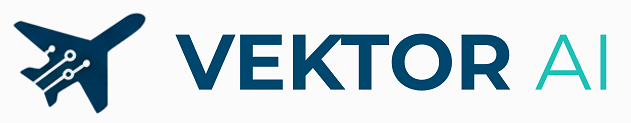

Se realizan pruebas con modelos Random Forest, Regresión Logística, XGBoost y LightGBM con GridSearch para encontrar la mejor combinación de hiperparámetros para los datos con variables de clima y generar el modelo final para elproducto mínimo viable (MVP). El único modelo que no corrió exitosamente corresponde al LightGBM por motivos de procesamiento a pesar de que se utilizó una cuenta Colab Pro con entorno de ejecución TPU v5e-1. De los tres modelos que corrieron exitosamente, el mejor modelo resultó ser **XGBoost** (accuracy = 0.763, ROC AUC =0.831, 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 400, 'subsample': 0.8) seguido de cerca por **Random Forest** (accuracy = 0.752, ROC AUC=0.807,'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 16, 'min_samples_split': 5, 'n_estimators': 100) y XGBoost .

|XGBoost|Precisión|Recall|F1-score|Support|
|------|------|------|-------|--------|
|0.0|0.92|0.77|0.84|1654099|
|1.0|0.45|0.73|0.56|420496|
|accuracy|||0.76|2074595|
|macro avg|0.68|0.75|0.70|2074595|
|weighted avg|0.82|0.76|0.78|2074595|
||||||

|Random Forest|Precisión|Recall|F1-score|Support|
|------|------|------|-------|--------|
|0.0|0.91|0.77|0.83|1654099|
|1.0|0.43|0.69|0.53|4200496|
|accuracy|||0.75|2074595|
|macro avg|0.67|0.73|0.68|2074595|
|weighted avg|0.81|0.75|0.77|2074595|


## **0. Descripción de las Variables**

**Time Period:**

1. **QUARTER:** Quarter(1-4)

2. **MONTH:** Month

3. **DAY_OF_MONTH:** Day of the Month

4. **FL_DATE:** Flight Date (yyymmdd)

**Airline**

5. **OP_UNIQUE_CARRIER:** Unique Carrier Code. When the same code has been used by multiple carriers, a numeric suffix is used for earlier users, for example, PA, PA(1), PA(2). Use this field for analysis across a range of years.

6. **TAIL_NUM:** Tail Number

**Origin**

7. **ORIGIN_AIRPORT_ID:** Origin Airport, Airport ID. An identification number assigned by US DOT to identify a unique airport. Use this field for airport analysis across a range of years because an airport can change its airport code and airport codes can be reused.

8. **ORIGIN:** 	Origin Airport

**Destination**

9. **DEST_AIRPORT_ID:** Destination Airport, Airport ID. An identification number assigned by US DOT to identify a unique airport. Use this field for airport analysis across a range of years because an airport can change its airport code and airport codes can be reused.

10. **DEST:**	Destination Airport

**Departure Performance**

11. **CRS_DEP_TIME:**	CRS Departure Time (local time: hhmm)

12. **DEP_DEL15:**	Departure Delay Indicator, 15 Minutes or More (1=Yes)

**Arrival Performance**

13. **CRS_ARR_TIME:**	CRS Arrival Time (local time: hhmm)

**Weather Variables**

14. **temperatura**: temperatura ambiental medida en la estación meteorológica más cercana

15. **humedad**: humedad ambiental medida en la estación meteorológica más cercana

16. **presion**: presión atmosférica medida en la estación meteorológica más cercana

17. **visibilidad**: visibilidad medida en la estación meteorológica más cercana

18. **viento_velocidad**: Velocidad del viento medida en la estación meteorológica más cercana

19. **condición**: condición atmosférica medida en la estación meteorológica más cercana

# **Random Forest**

## **1. Importación Librerías y Configuración**

In [ ]:
import pandas as pd
import numpy as np
import joblib
import kagglehub
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

MODEL_OUTPUT = "random_forest_gridsearch_v3.joblib"
DATASET_REF = "spmv1980/hackaton-2025-equipo-71"

## **2. Descarga del Set de Datos**

In [ ]:
print(f"⬇️ Descargando dataset desde Kaggle ({DATASET_REF})...")
path = kagglehub.dataset_download(DATASET_REF)
csv_path = os.path.join(path, "df_procesado_clima.csv")

if not os.path.exists(csv_path):
    raise FileNotFoundError("❌ No se encontró el archivo CSV")

print(f"📂 Dataset localizado en: {csv_path}")


⬇️ Descargando dataset desde Kaggle (spmv1980/hackaton-2025-equipo-71)...


100%|██████████| 1.22G/1.22G [00:30<00:00, 43.0MB/s]

Extracting files...


📂 Dataset localizado en: /root/.cache/kagglehub/datasets/spmv1980/hackaton-2025-equipo-71/versions/14/df_procesado_clima.csv


## **3. Feature Engineering**

In [ ]:
def feature_engineering(df):
    df = df.copy()

    if 'FL_DATE' in df.columns:
        df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
        df['mes'] = df['FL_DATE'].dt.month
        df['dia_semana'] = df['FL_DATE'].dt.dayofweek

        df['mes_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
        df['mes_cos'] = np.cos(2 * np.pi * df['mes'] / 12)

        df['dia_semana_sin'] = np.sin(2 * np.pi * df['dia_semana'] / 7)
        df['dia_semana_cos'] = np.cos(2 * np.pi * df['dia_semana'] / 7)

        df['es_fin_de_semana'] = (df['dia_semana'] >= 5).astype(int)

    return df

## **4. Carga y Preparación de Datos**

In [ ]:
print("\n📖 Leyendo CSV...")
df = pd.read_csv(csv_path)


📖 Leyendo CSV...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6915315 entries, 0 to 6915314
Data columns (total 34 columns):
 #   Column               Dtype  
---  ------               -----  
 0   QUARTER              int64  
 1   MONTH                int64  
 2   DAY_OF_MONTH         int64  
 3   DAY_OF_WEEK          int64  
 4   FL_DATE              object 
 5   OP_UNIQUE_CARRIER    object 
 6   TAIL_NUM             object 
 7   OP_CARRIER_FL_NUM    int64  
 8   ORIGIN_AIRPORT_ID    int64  
 9   ORIGIN               object 
 10  DEST_AIRPORT_ID      int64  
 11  DEST                 object 
 12  CRS_DEP_TIME         int64  
 13  DEP_TIME             object 
 14  DEP_DELAY            float64
 15  DEP_DEL15            float64
 16  CRS_ARR_TIME         int64  
 17  ARR_TIME             float64
 18  ARR_DELAY            float64
 19  ARR_DEL15            float64
 20  CANCELLED            float64
 21  DIVERTED             float64
 22  ACTUAL_ELAPSED_TIME  float64
 23  DISTANCE             float64
 24

In [ ]:
df.head()

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,WEATHER_DELAY,HAS_FIRST_DEP_TIME,HAS_TOTAL_ADD_GTIME,FECHA_PARTIDA,temperatura,humedad,presion,visibilidad,viento_velocidad,condicion
0,4,10,1,2,2024-10-01,9E,N132EV,5020,12953,LGA,...,0.0,0,0,2024-10-01 15:44:00,20.30,62.0,1015.50,16.09,5.40,RA
1,4,10,1,2,2024-10-01,9E,N132EV,5025,10431,AVL,...,33.0,0,0,2024-10-01 13:06:00,22.20,68.0,938.40,16.00,5.10,BR
2,4,10,1,2,2024-10-01,9E,N132EV,5025,12953,LGA,...,43.0,0,0,2024-10-01 09:42:00,18.30,71.5,1017.35,16.09,6.20,RA
3,4,10,1,2,2024-10-01,9E,N132EV,5065,11618,EWR,...,0.0,0,0,2024-10-01 21:06:00,18.05,71.5,1015.65,16.09,3.35,RA
4,4,10,1,2,2024-10-01,9E,N132EV,5222,14492,RDU,...,0.0,0,0,2024-10-01 18:37:00,22.20,85.5,996.85,16.09,2.05,||RA


In [ ]:
print("⚙️ Aplicando feature engineering...")
df = feature_engineering(df)

print("🔠 Codificando variables categóricas...")
encoders = {}
cat_cols = ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'TAIL_NUM','condicion']

for col in cat_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        encoders[col] = le

⚙️ Aplicando feature engineering...
🔠 Codificando variables categóricas...


## **5. Features y Target**

In [ ]:
features = [
    'mes_sin', 'mes_cos',
    'dia_semana_sin', 'dia_semana_cos',
    'es_fin_de_semana',
    'MONTH', 'QUARTER', 'DAY_OF_MONTH',
    'OP_UNIQUE_CARRIER', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID',
    'CRS_DEP_TIME', 'CRS_ARR_TIME', 'TAIL_NUM',
    'temperatura','humedad','presion','visibilidad','viento_velocidad',
    'condicion'
]

for f in features:
    if f not in df.columns:
        print(f"⚠️ Columna {f} no encontrada, se rellena con 0")
        df[f] = 0

X = df[features]
y = df['DEP_DEL15']

## **6. Train/Test Split**

In [ ]:
print("✂️ Dividiendo Train/Test (70/30)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

✂️ Dividiendo Train/Test (70/30)...


## **7. GridSearch para Random Forest**

In [ ]:
print("\n🔎 Iniciando GridSearchCV...") # Toma 14 horas

rf_base = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=1 # Changed from -1 to 1 to prevent OOM errors during parallel processing
)

param_grid = {
    'n_estimators': [80, 100],
    'max_depth': [18, 22, None],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [8, 16],
    'max_features': ['sqrt']
}

grid = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,
    scoring='recall',
    verbose=2,
    n_jobs=1 # Changed from -1 to 1 to prevent OOM errors during parallel processing
)

grid.fit(X_train, y_train)

print("\n🏆 Mejores hiperparámetros encontrados:")
print(grid.best_params_)



🔎 Iniciando GridSearchCV...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END max_depth=18, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=80; total time= 9.6min
[CV] END max_depth=18, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=80; total time= 9.5min
[CV] END max_depth=18, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=80; total time= 9.5min
[CV] END max_depth=18, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=100; total time=12.0min
[CV] END max_depth=18, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=100; total time=11.9min
[CV] END max_depth=18, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=100; total time=11.8min
[CV] END max_depth=18, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=80; total time= 9.6min
[CV] END max_depth=18, max_features=sqrt, min_samples_leaf=8, min_samples

## **8. Modelo Final**

In [ ]:
rf = grid.best_estimator_

## **9. Evaluación**

In [ ]:
from sklearn.metrics import recall_score, f1_score

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 0.9, 0.05)

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    print(
        f"t={t:.2f} | recall_1={recall_score(y_test, y_pred_t):.3f}"
    )

print("\n📊 Accuracy:", accuracy_score(y_test, y_pred))
print("📈 ROC AUC:", roc_auc_score(y_test, y_prob))

print("\n🧮 Matriz de confusión (threshold=0.5):")
print(confusion_matrix(y_test, y_pred))

print("\n📋 Reporte de clasificación:")
print(classification_report(y_test, y_pred))

t=0.10 | recall_1=1.000
t=0.15 | recall_1=0.996
t=0.20 | recall_1=0.987
t=0.25 | recall_1=0.969
t=0.30 | recall_1=0.944
t=0.35 | recall_1=0.907
t=0.40 | recall_1=0.855
t=0.45 | recall_1=0.785
t=0.50 | recall_1=0.693
t=0.55 | recall_1=0.586
t=0.60 | recall_1=0.472
t=0.65 | recall_1=0.363
t=0.70 | recall_1=0.266
t=0.75 | recall_1=0.181
t=0.80 | recall_1=0.111
t=0.85 | recall_1=0.055

📊 Accuracy: 0.7515780188422319
📈 ROC AUC: 0.8069002634346725

🧮 Matriz de confusión (threshold=0.5):
[[1267744  386355]
 [ 129020  291476]]

📋 Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.91      0.77      0.83   1654099
         1.0       0.43      0.69      0.53    420496

    accuracy                           0.75   2074595
   macro avg       0.67      0.73      0.68   2074595
weighted avg       0.81      0.75      0.77   2074595



## **10. Matriz de Confusión Normalizada**

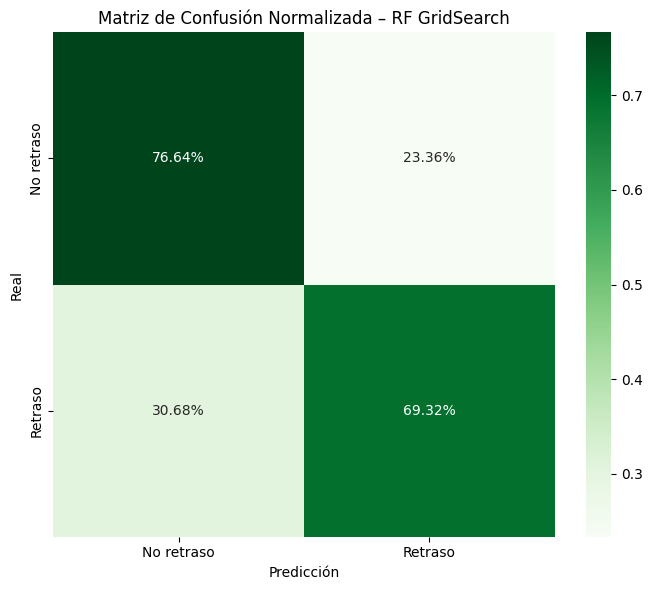

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2%",
    cmap="Greens",
    xticklabels=["No retraso", "Retraso"],
    yticklabels=["No retraso", "Retraso"]
)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión Normalizada – RF GridSearch")
plt.tight_layout()
plt.show()


## **11. Importacnia de Variables**

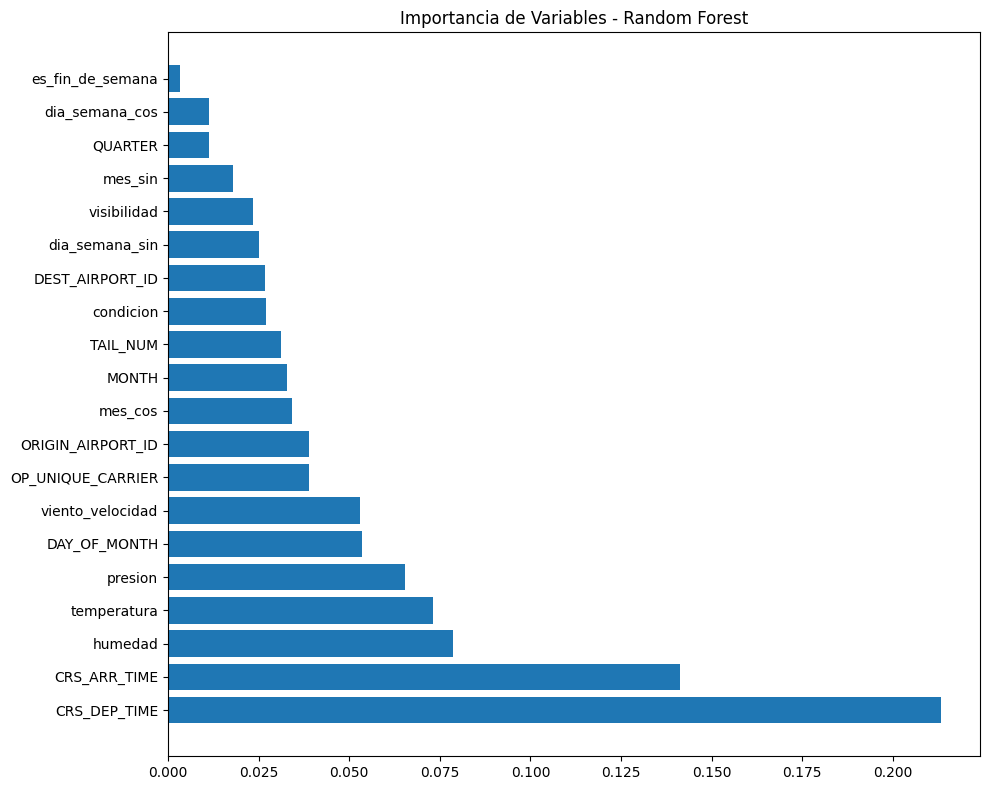

In [ ]:
importancias = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': rf.feature_importances_
}).sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(10,8))
plt.barh(importancias['Variable'], importancias['Importancia'])
plt.title("Importancia de Variables - Random Forest")
plt.tight_layout()
plt.show()

## **12. Curva ROC**

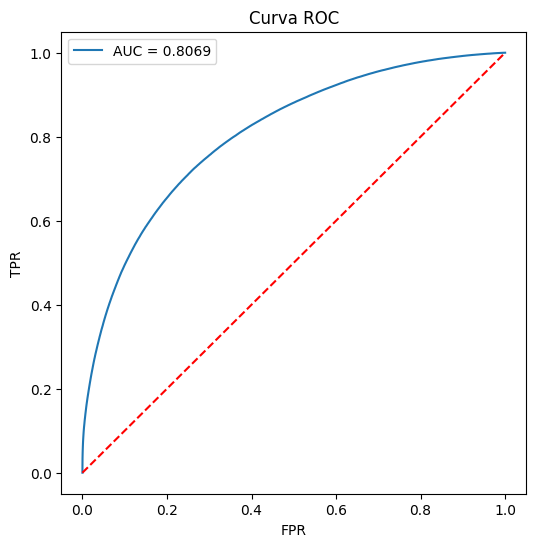

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], 'r--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC")
plt.legend()
plt.show()

## **13. Curva Precision-Recall**

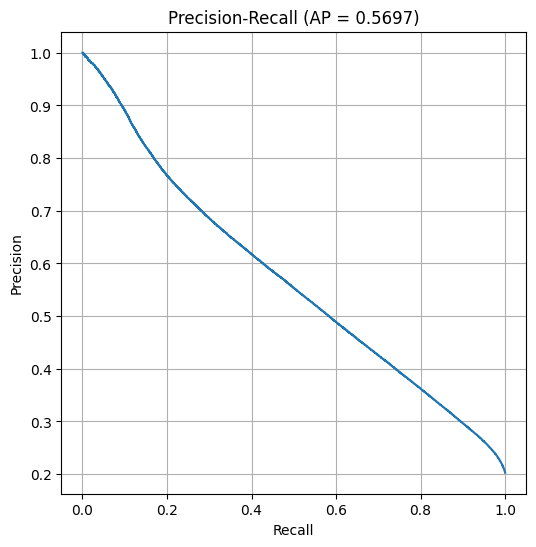

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6,6))
plt.step(recall, precision, where='post')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall (AP = {ap:.4f})")
plt.grid(True)
plt.show()

## **14. Guardado del Modelo**

In [ ]:
artifact = {
    "model": rf,
    "threshold": 0.30,
    "encoders": encoders,
    "features": features,
    "feature_engineering": feature_engineering,
    "best_params": grid.best_params_
}

print(f"\n💾 Guardando modelo en {MODEL_OUTPUT}")
joblib.dump(artifact, MODEL_OUTPUT, compress=3)

print("⬇️ Descargando modelo...")
files.download(MODEL_OUTPUT)

print("✅ Proceso finalizado con éxito")


💾 Guardando modelo en random_forest_gridsearch_v3.joblib
⬇️ Descargando modelo...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Proceso finalizado con éxito


# **Regresión Logistica**

## **1. Importación Librerías y Configuración**

In [ ]:
import pandas as pd
import numpy as np
import joblib
import kagglehub
import os

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files

MODEL_OUTPUT = "logistic_regression_v1.joblib"
DATASET_REF = "spmv1980/hackaton-2025-equipo-71"


## **2. Carga del set de datos**

In [ ]:
print(f"⬇️ Descargando dataset desde Kaggle ({DATASET_REF})...")
path = kagglehub.dataset_download(DATASET_REF)
csv_path = os.path.join(path, "df_procesado_clima.csv")

if os.path.exists(csv_path):
    print(f"📂 Dataset localizado en: {csv_path}")
else:
    raise FileNotFoundError("❌ No se encontró el archivo CSV")

⬇️ Descargando dataset desde Kaggle (spmv1980/hackaton-2025-equipo-71)...
Using Colab cache for faster access to the 'hackaton-2025-equipo-71' dataset.
📂 Dataset localizado en: /kaggle/input/hackaton-2025-equipo-71/df_procesado_clima.csv


## **3. Feature Engineering**

In [ ]:
def feature_engineering(df):
    """
    Genera características temporales y cíclicas.
    """
    df = df.copy()

    if 'FL_DATE' in df.columns:
        df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])

        df['mes'] = df['FL_DATE'].dt.month
        df['dia_semana'] = df['FL_DATE'].dt.dayofweek

        # Features cíclicas
        df['mes_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
        df['mes_cos'] = np.cos(2 * np.pi * df['mes'] / 12)

        df['dia_semana_sin'] = np.sin(2 * np.pi * df['dia_semana'] / 7)
        df['dia_semana_cos'] = np.cos(2 * np.pi * df['dia_semana'] / 7)

        df['es_fin_de_semana'] = (df['dia_semana'] >= 5).astype(int)

    return df


## **4. Carga y Preprocesamiento**

In [ ]:
print("\n📖 Leyendo CSV...")
df = pd.read_csv(csv_path)

print("⚙️ Aplicando feature engineering...")
df = feature_engineering(df)

# Codificación de variables categóricas
print("🔠 Codificando variables categóricas...")
encoders = {}
cat_cols = ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'TAIL_NUM','condicion']

for col in cat_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        encoders[col] = le



📖 Leyendo CSV...
⚙️ Aplicando feature engineering...
🔠 Codificando variables categóricas...


## **5. Features**

In [ ]:
features = [
    'mes_sin', 'mes_cos',
    'dia_semana_sin', 'dia_semana_cos',
    'es_fin_de_semana',
    'MONTH', 'QUARTER', 'DAY_OF_MONTH',
    'OP_UNIQUE_CARRIER', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID',
    'CRS_DEP_TIME', 'CRS_ARR_TIME', 'TAIL_NUM',
    'temperatura','humedad','presion','visibilidad','viento_velocidad',
    'condicion'
]

# Verificar columnas
for f in features:
    if f not in df.columns:
        print(f"⚠️ Columna faltante: {f}. Se rellena con 0.")
        df[f] = 0

X = df[features]
y = df['DEP_DEL15']

## **6. Train/Test Split**

In [ ]:
print("✂️ Dividiendo Train/Test (70/30)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

✂️ Dividiendo Train/Test (70/30)...


## **7. Escalado (Requerido para Regresión Logística)**

In [ ]:
print("📐 Escalando variables numéricas...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

📐 Escalando variables numéricas...


## **8. GridSearch -Regresión Logística**

In [ ]:
print("🧠 Entrenando Regresión Logística con GridSearch...")

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='liblinear'
)

param_grid = {
    'C': [0.01, 0.1, 1, 5, 10],
    'penalty': ['l1', 'l2']
}

grid = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='recall',
    cv=4,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train_scaled, y_train)

best_model = grid.best_estimator_

print("✅ Mejores hiperparámetros:")
print(grid.best_params_)

🧠 Entrenando Regresión Logística con GridSearch...
Fitting 4 folds for each of 10 candidates, totalling 40 fits
✅ Mejores hiperparámetros:
{'C': 0.01, 'penalty': 'l1'}


## **9. Evaluación**

In [ ]:
y_pred = best_model.predict(X_test_scaled)
y_pred_prob = best_model.predict_proba(X_test_scaled)[:, 1]

thresholds = np.arange(0.1, 0.9, 0.05)

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    print(
        f"t={t:.2f} | recall_1={recall_score(y_test, y_pred_t):.3f}"
    )

print("\n📊 Accuracy:", accuracy_score(y_test, y_pred))
print("📈 ROC AUC:", roc_auc_score(y_test, y_pred_prob))

print("\n📋 Reporte de clasificación:")
print(classification_report(y_test, y_pred))

t=0.10 | recall_1=1.000
t=0.15 | recall_1=0.996
t=0.20 | recall_1=0.987
t=0.25 | recall_1=0.969
t=0.30 | recall_1=0.944
t=0.35 | recall_1=0.907
t=0.40 | recall_1=0.855
t=0.45 | recall_1=0.785
t=0.50 | recall_1=0.693
t=0.55 | recall_1=0.586
t=0.60 | recall_1=0.472
t=0.65 | recall_1=0.363
t=0.70 | recall_1=0.266
t=0.75 | recall_1=0.181
t=0.80 | recall_1=0.111
t=0.85 | recall_1=0.055

📊 Accuracy: 0.6036590274246298
📈 ROC AUC: 0.6554785044405798

📋 Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.87      0.60      0.71   1654099
         1.0       0.29      0.63      0.39    420496

    accuracy                           0.60   2074595
   macro avg       0.58      0.62      0.55   2074595
weighted avg       0.75      0.60      0.64   2074595



## **10. Matriz de Confusión Normalizada**

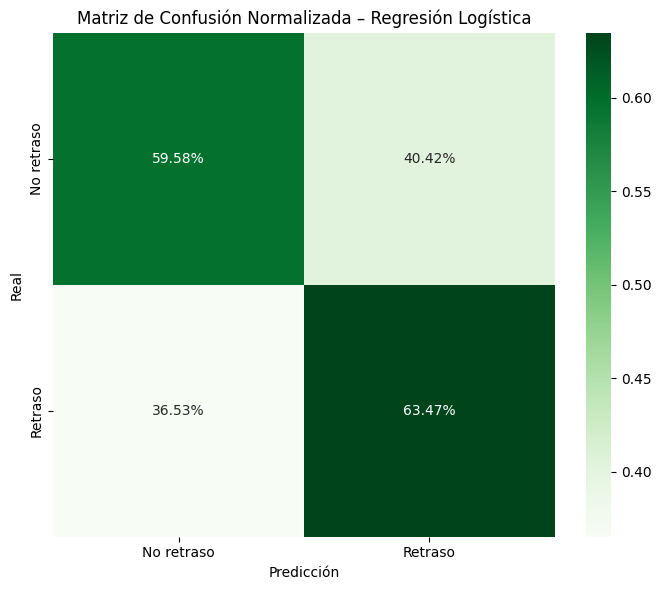

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.2%',
    cmap='Greens',
    xticklabels=['No retraso', 'Retraso'],
    yticklabels=['No retraso', 'Retraso']
)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión Normalizada – Regresión Logística")
plt.tight_layout()
plt.show()


## **11. Curva ROC**

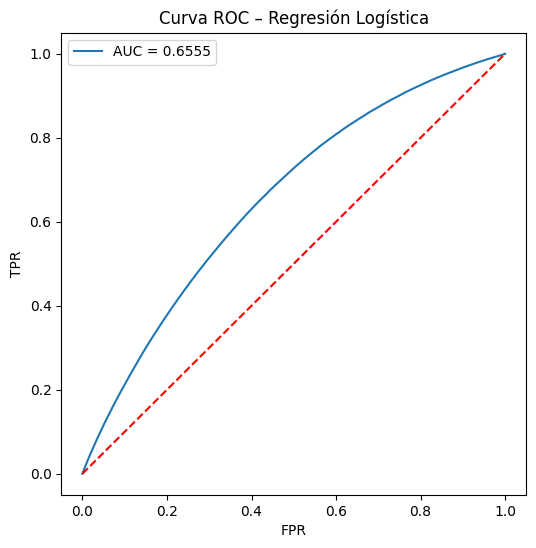

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle='--', color='red')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC – Regresión Logística")
plt.legend()
plt.show()

## **12. Curva Precision-Recall**

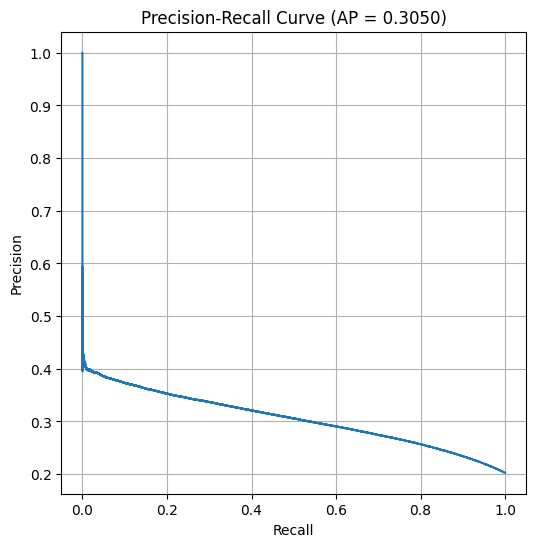

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
ap = average_precision_score(y_test, y_pred_prob)

plt.figure(figsize=(6,6))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (AP = {ap:.4f})")
plt.grid(True)
plt.show()

## **13. Guardado de Modelo**

In [ ]:
artifact = {
    "model": best_model,
    "threshold": 0.30,
    "scaler": scaler,
    "encoders": encoders,
    "features": features,
    "feature_engineering": feature_engineering
}

print(f"💾 Guardando modelo: {MODEL_OUTPUT}")
joblib.dump(artifact, MODEL_OUTPUT, compress=3)

print("⬇️ Descargando modelo...")
files.download(MODEL_OUTPUT)

print("✅ Proceso finalizado correctamente")

💾 Guardando modelo: logistic_regression_v1.joblib
⬇️ Descargando modelo...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Proceso finalizado correctamente


# **XGBoost**

## **1. Importación Librerías y Configuración**

In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.8/289.8 MB 13.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import joblib
import kagglehub
import os

from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files

MODEL_OUTPUT = "xgboost_v1.joblib"
DATASET_REF = "spmv1980/hackaton-2025-equipo-71"

## **2. Descarga del Set de datos**

In [ ]:
print(f"⬇️ Descargando dataset desde Kaggle ({DATASET_REF})...")
path = kagglehub.dataset_download(DATASET_REF)
csv_path = os.path.join(path, "df_procesado_clima.csv")

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"No se encontró el archivo CSV en {path}")

print(f"📂 Dataset localizado en: {csv_path}")

⬇️ Descargando dataset desde Kaggle (spmv1980/hackaton-2025-equipo-71)...


100%|██████████| 1.22G/1.22G [00:30<00:00, 42.9MB/s]

Extracting files...


📂 Dataset localizado en: /root/.cache/kagglehub/datasets/spmv1980/hackaton-2025-equipo-71/versions/14/df_procesado_clima.csv


## **3. Feature Engineering**

In [ ]:
def feature_engineering(df):
    df = df.copy()

    if 'FL_DATE' in df.columns:
        df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
        df['mes'] = df['FL_DATE'].dt.month
        df['dia_semana'] = df['FL_DATE'].dt.dayofweek

        df['mes_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
        df['mes_cos'] = np.cos(2 * np.pi * df['mes'] / 12)

        df['dia_semana_sin'] = np.sin(2 * np.pi * df['dia_semana'] / 7)
        df['dia_semana_cos'] = np.cos(2 * np.pi * df['dia_semana'] / 7)

        df['es_fin_de_semana'] = (df['dia_semana'] >= 5).astype(int)

    return df

## **4. Carga y Preparación de Datos**

In [ ]:
print("📖 Leyendo CSV...")
df = pd.read_csv(csv_path)

print("⚙️ Aplicando feature engineering...")
df = feature_engineering(df)

📖 Leyendo CSV...
⚙️ Aplicando feature engineering...


## **5. Codificación de Variables Categóricas**

In [ ]:
print("🔠 Codificando variables categóricas...")
encoders = {}
cat_cols = ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'TAIL_NUM','condicion']

for col in cat_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        encoders[col] = le

🔠 Codificando variables categóricas...


## **6. Features**

In [ ]:
features = [
    'mes_sin', 'mes_cos',
    'dia_semana_sin', 'dia_semana_cos',
    'es_fin_de_semana',
    'MONTH', 'QUARTER', 'DAY_OF_MONTH',
    'OP_UNIQUE_CARRIER', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID',
    'CRS_DEP_TIME', 'CRS_ARR_TIME', 'TAIL_NUM',
    'temperatura','humedad','presion','visibilidad','viento_velocidad',
    'condicion'
]

for f in features:
    if f not in df.columns:
        df[f] = 0

X = df[features]
y = df['DEP_DEL15']


## **7. Train/Test Split**

In [ ]:
print("✂️ Train/Test split 70/30...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

✂️ Train/Test split 70/30...


In [ ]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

## **8. XGBoost + GridSearch**

In [ ]:
print("🧠 Entrenando XGBoost con GridSearch...")

xgb_base = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])
)

param_grid = {
    'n_estimators': [200, 400],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='recall',
    cv=2,
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_

print("✅ Mejores hiperparámetros:")
print(grid.best_params_)

🧠 Entrenando XGBoost con GridSearch...
Fitting 2 folds for each of 48 candidates, totalling 96 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


✅ Mejores hiperparámetros:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 400, 'subsample': 0.8}


## **9. Evaluación**

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    recall_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)


In [ ]:
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 0.9, 0.05)

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    print(
        f"t={t:.2f} | recall_1={recall_score(y_test, y_pred_t):.3f}"
    )

print("\n📊 Accuracy:", accuracy_score(y_test, y_pred))
print("📈 ROC AUC:", roc_auc_score(y_test, y_prob))

print("\n🧮 Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\n📋 Reporte de clasificación:")
print(classification_report(y_test, y_pred))

t=0.10 | recall_1=0.998
t=0.15 | recall_1=0.991
t=0.20 | recall_1=0.978
t=0.25 | recall_1=0.958
t=0.30 | recall_1=0.930
t=0.35 | recall_1=0.894
t=0.40 | recall_1=0.847
t=0.45 | recall_1=0.792
t=0.50 | recall_1=0.729
t=0.55 | recall_1=0.658
t=0.60 | recall_1=0.581
t=0.65 | recall_1=0.500
t=0.70 | recall_1=0.418
t=0.75 | recall_1=0.333
t=0.80 | recall_1=0.248
t=0.85 | recall_1=0.167

📊 Accuracy: 0.763434790886896
📈 ROC AUC: 0.8310515193581424

🧮 Matriz de confusión:
[[1277346  376753]
 [ 114024  306472]]

📋 Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.92      0.77      0.84   1654099
         1.0       0.45      0.73      0.56    420496

    accuracy                           0.76   2074595
   macro avg       0.68      0.75      0.70   2074595
weighted avg       0.82      0.76      0.78   2074595



## **10. Matriz de Confusión Normalizada**

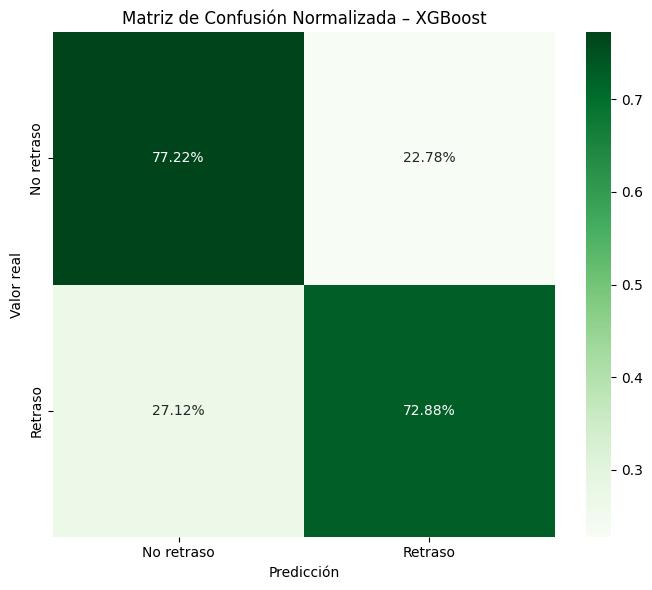

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.2%',
    cmap='Greens',
    xticklabels=['No retraso', 'Retraso'],
    yticklabels=['No retraso', 'Retraso']
)
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión Normalizada – XGBoost")
plt.tight_layout()
plt.show()


## **11. Curva ROC**

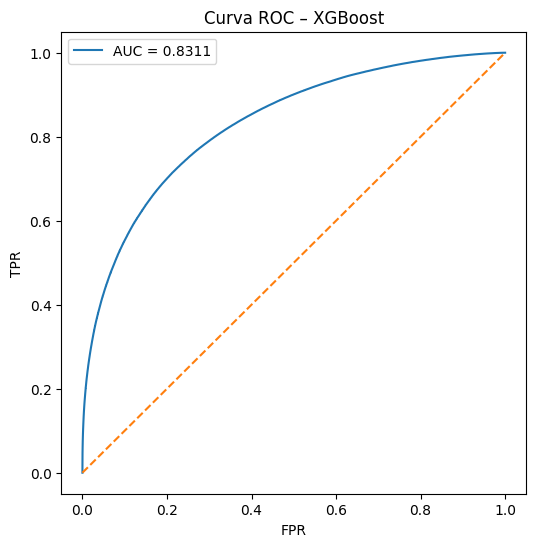

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC – XGBoost")
plt.legend()
plt.show()

## **12. Curva Precision-Recall**

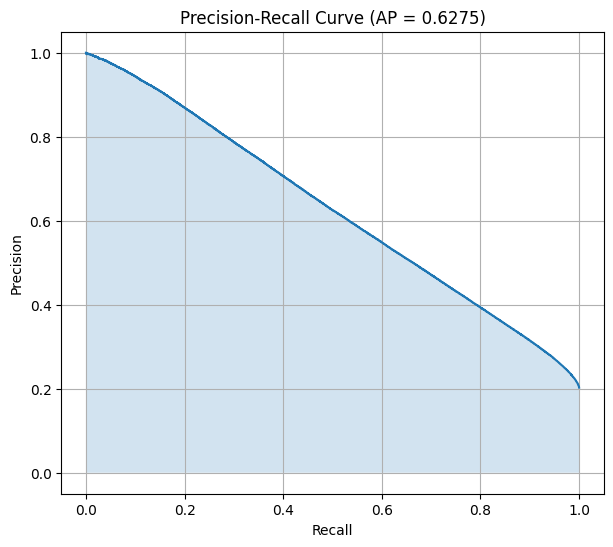

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(7,6))
plt.step(recall, precision, where='post')
plt.fill_between(recall, precision, alpha=0.2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (AP = {ap:.4f})")
plt.grid(True)
plt.show()


## **13. Importancia de Variables**

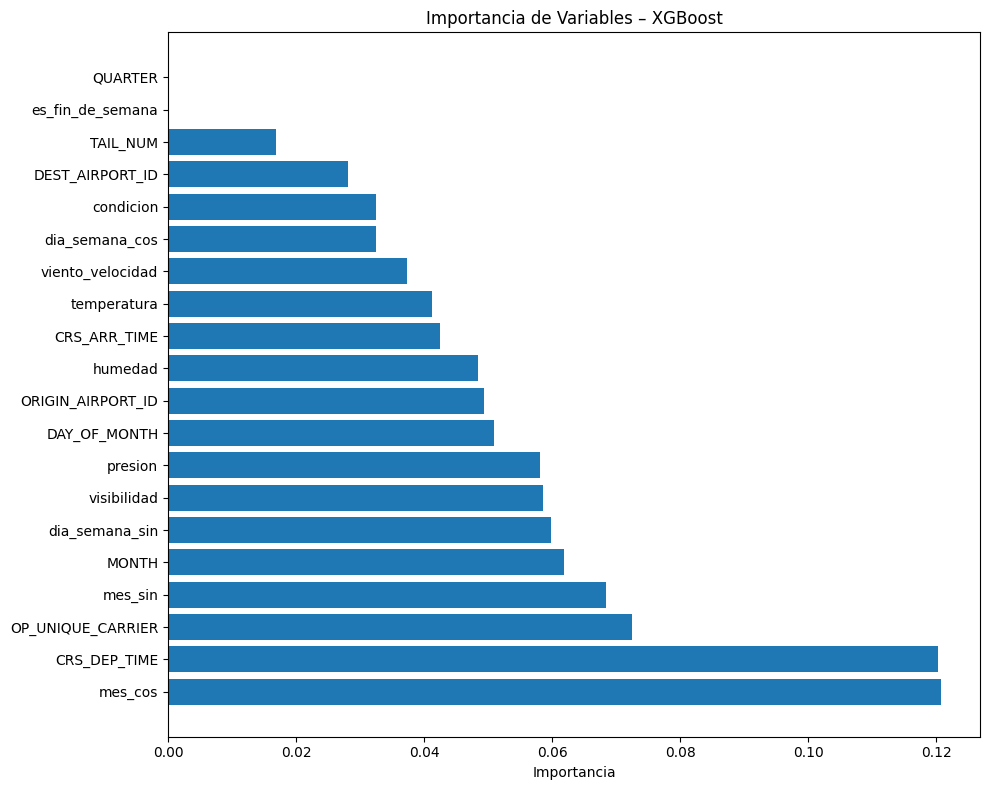

In [ ]:
importancias = pd.DataFrame({
    'Variable': X_train.columns,
    'Importancia': best_model.feature_importances_
}).sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(10,8))
plt.barh(importancias['Variable'], importancias['Importancia'])
plt.xlabel("Importancia")
plt.title("Importancia de Variables – XGBoost")
plt.tight_layout()
plt.show()

## **14. Guardado del Modelo**

In [ ]:
artifact = {
    "model": best_model,
    "threshold": 0.30,
    "encoders": encoders,
    "features": features,
    "feature_engineering": feature_engineering,
    "best_params": grid.best_params_
}

print(f"💾 Guardando modelo: {MODEL_OUTPUT}")
joblib.dump(artifact, MODEL_OUTPUT, compress=3)

print("⬇️ Descargando modelo...")
files.download(MODEL_OUTPUT)

print("✅ Proceso finalizado con éxito.")

💾 Guardando modelo: xgboost_v1.joblib
⬇️ Descargando modelo...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Proceso finalizado con éxito.


# **LightGBM**

## **1. Importación de Librerías y Configuración**

In [1]:
!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import joblib
import kagglehub
import os
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

from google.colab import files

MODEL_OUTPUT = "lightgbm_v1.joblib"
DATASET_REF = "spmv1980/hackaton-2025-equipo-71"


## **2. Descarga del Set de datos**

In [3]:
print(f"⬇️ Descargando dataset desde Kaggle ({DATASET_REF})...")
path = kagglehub.dataset_download(DATASET_REF)
csv_path = os.path.join(path, "df_procesado_clima.csv")

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"No se encontró el CSV en {path}")

print(f"📂 Dataset localizado en: {csv_path}")

⬇️ Descargando dataset desde Kaggle (spmv1980/hackaton-2025-equipo-71)...
Using Colab cache for faster access to the 'hackaton-2025-equipo-71' dataset.
📂 Dataset localizado en: /kaggle/input/hackaton-2025-equipo-71/df_procesado_clima.csv


## **3. Feature Engineering**

In [4]:
def feature_engineering(df):
    df = df.copy()

    if 'FL_DATE' in df.columns:
        df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])

        df['mes'] = df['FL_DATE'].dt.month
        df['dia_semana'] = df['FL_DATE'].dt.dayofweek

        # Cíclicas
        df['mes_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
        df['mes_cos'] = np.cos(2 * np.pi * df['mes'] / 12)

        df['dia_semana_sin'] = np.sin(2 * np.pi * df['dia_semana'] / 7)
        df['dia_semana_cos'] = np.cos(2 * np.pi * df['dia_semana'] / 7)

        df['es_fin_de_semana'] = (df['dia_semana'] >= 5).astype(int)

    return df

## **4. Carga y Preprocesamiento**

In [5]:
print("\n📖 Leyendo CSV...")
df = pd.read_csv(csv_path)

print("⚙️ Feature engineering...")
df = feature_engineering(df)

# Codificación categórica
print("🔠 Codificando variables categóricas...")
encoders = {}
cat_cols = ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'TAIL_NUM','condicion']

for col in cat_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        encoders[col] = le


📖 Leyendo CSV...
⚙️ Feature engineering...
🔠 Codificando variables categóricas...


## **5. Features y Target**

---



In [6]:
features = [
    'mes_sin', 'mes_cos',
    'dia_semana_sin', 'dia_semana_cos',
    'es_fin_de_semana',
    'MONTH', 'QUARTER', 'DAY_OF_MONTH',
    'OP_UNIQUE_CARRIER', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID',
    'CRS_DEP_TIME', 'CRS_ARR_TIME', 'TAIL_NUM',
    'temperatura','humedad','presion','visibilidad','viento_velocidad',
    'condicion'
]

for f in features:
    if f not in df.columns:
        print(f"⚠️ Columna faltante {f}, se rellena con 0")
        df[f] = 0

X = df[features]
y = df['DEP_DEL15']


## **6. Train/Test Split**

In [7]:
print("✂️ Train / Test split (70/30)")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

✂️ Train / Test split (70/30)


## **7. GridSearch LightGBM**

In [ ]:
print("\n🔍 Iniciando GridSearch LightGBM...")

lgbm = LGBMClassifier(
    objective='binary',
    class_weight='balanced',
    random_state=42,
    n_jobs=1
)

param_grid = {
    'n_estimators': [200, 400],
    'learning_rate': [0.05, 0.1],
    'max_depth': [6, 10, -1],
    'num_leaves': [31, 63],
    'min_child_samples': [20, 40],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='recall',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_

print("\n🏆 Mejores hiperparámetros:")
print(grid.best_params_)


🔍 Iniciando GridSearch LightGBM...
Fitting 3 folds for each of 192 candidates, totalling 576 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


## **8. Evaluación**

In [ ]:
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 0.9, 0.05)

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    print(
        f"t={t:.2f} | recall_1={recall_score(y_test, y_pred_t):.3f}"
    )

print("\n📊 Métricas:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred))

## **9. Matriz de Confusión**

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.2%',
    cmap='Greens',
    xticklabels=['No retraso', 'Retraso'],
    yticklabels=['No retraso', 'Retraso']
)
plt.title('Matriz de Confusión Normalizada – LightGBM')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

## **10. Curva ROC**

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC – LightGBM')
plt.legend()
plt.show()

## **11. Curva Precision-Recall**

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, label=f'AP = {ap:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve – LightGBM')
plt.legend()
plt.grid(True)
plt.show()

## **12. Importancia de Variables**

In [ ]:
importancias = pd.DataFrame({
    'Variable': features,
    'Importancia': best_model.feature_importances_
}).sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(10,8))
plt.barh(importancias['Variable'], importancias['Importancia'])
plt.title('Importancia de Variables – LightGBM')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## **13. Guardado del Modelo**

In [ ]:
artifact = {
    "model": best_model,
    "threshold": 0.30,
    "encoders": encoders,
    "features": features,
    "feature_engineering": feature_engineering,
    "best_params": grid.best_params_
}

print(f"💾 Guardando modelo: {MODEL_OUTPUT}")
joblib.dump(artifact, MODEL_OUTPUT, compress=3)

print("⬇️ Descargando archivo...")
files.download(MODEL_OUTPUT)

print("✅ Proceso completado correctamente")